Карпеченко Дмитрий, дз 33
Цель - впихнуть в модель слой MultiHeadAttention :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter
import os
#import cv2
import random
import tensorflow as tf

from tensorflow import keras

In [2]:
from imutils import paths
import face_recognition
import pickle
import cv2
import os

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6107526445792631651
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4841275392
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15912486542774991761
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [4]:
# Загружаем файл каскада Хаарта
faceCascade = cv2.CascadeClassifier(r"D:\TeachMeSkills\DZ\dz22\haarcascade_frontalface_alt2.xml")

In [5]:
imagePaths =r'D:\TeachMeSkills\DZ\dz27\wiki_crop'

In [6]:
from tqdm import tqdm

In [7]:
df = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for dirname, _,filenames in tqdm(os.walk(imagePaths)):
    for filename in filenames:
        #формируем ссылку на изображение
        link = os.path.join(dirname, filename)
        
         #### Распознавание лица с помощью каскадов Хаара
        img = cv2.imread(link)
####        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img.shape[-1]==3:
            img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_new = img
        
        faces = faceCascade.detectMultiScale(img_new,
                                     scaleFactor=1.1,
                                     minNeighbors=5,
                                     minSize=(60, 60),
                                     flags=cv2.CASCADE_SCALE_IMAGE)
        if len(faces)==1:
            end = filename[-8:-4]
            start = filename.split('_')[1].split('-')[0]
            age = int(end)-int(start)
            x, y, w, h = faces[0]
            face_selected = img[y:y+h, x:x+h]
            link2 = os.path.join(r'D:\TeachMeSkills\DZ\dz27\wiki_crop\new', filename)
            cv2.imwrite(link2,face_selected)             ### Сохраним в файл с таким же именем, но в новую папку.\n",
            df.loc[len(df.index )] = [link2,age]
df.drop_duplicates (subset=['link'])            

102it [29:32, 17.37s/it] 


,link,age
0,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1004920...,67
1,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1011060...,27
2,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1012640...,46
3,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1013900...,43
4,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\1016640...,48
...,...,...
30616,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\9598699...,79
30617,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\961599_...,59
30618,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\9799_19...,52
30619,D:\TeachMeSkills\DZ\dz27\wiki_crop\new\981199_...,52


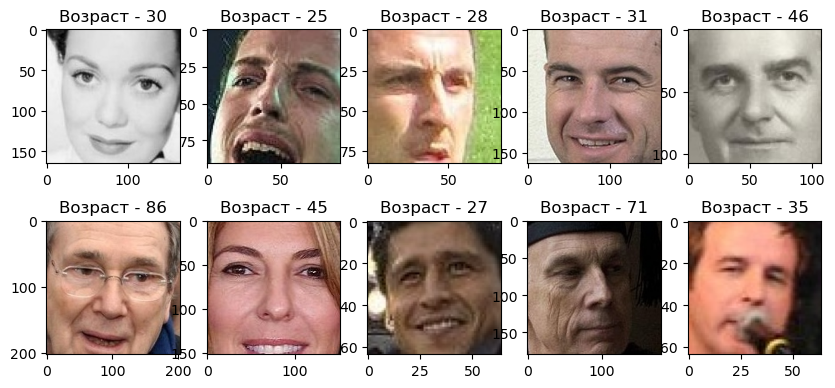

In [8]:
idx = np.random.randint (0,len(df),10)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = df.iloc[idx[1]]
        image = plt.imread(link[0])
        title = 'Возраст - ' + str(link[1])
        plt.title (title)
        plt.imshow(image, cmap='gray')

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,GlobalMaxPool2D, Conv2D, MaxPooling2D,Activation, Flatten, CategoryEncoding,Dropout, BatchNormalization, AveragePooling2D, MultiHeadAttention
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=34)

In [11]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [12]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

Found 30987 validated image filenames.
Found 13280 validated image filenames.
Found 11067 validated image filenames.


In [15]:
from tensorflow.keras.applications import resnet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input

In [16]:
input_1 = Input(shape=(128,128,3))

layer_Conv2D_1 = Conv2D(64, (3, 3), padding='same', activation='relu' )(input_1)
layer_MaxPool_1 = MaxPooling2D(pool_size=(2, 2), strides=2)(layer_Conv2D_1)
layer_Dropout_1 = Dropout(0.25)(layer_MaxPool_1)

layer_Conv2D_2 = Conv2D(32, (3, 3), padding='same', activation='relu' )(layer_Dropout_1)
layer_MaxPool_2 = MaxPooling2D(pool_size=(2, 2), strides=2)(layer_Conv2D_2)
layer_Dropout_2 = Dropout(0.25)(layer_MaxPool_2)

layer_Conv2D_3 = Conv2D(64, (3, 3), padding='same', activation='relu' )(layer_Dropout_2)
layer_MaxPool_3 = MaxPooling2D(pool_size=(2, 2), strides=2)(layer_Conv2D_3)
layer_Dropout_3 = Dropout(0.25)(layer_MaxPool_3)

layer_Conv2D_4 = Conv2D(128, (3, 3), padding='same', activation='relu' )(layer_Dropout_3)
layer_MaxPool_4 = MaxPooling2D(pool_size=(2, 2), strides=2)(layer_Conv2D_4)
layer_Dropout_4 = Dropout(0.25)(layer_MaxPool_4)

layer_Conv2D_5 = Conv2D(512, (3, 3), padding='same', activation='relu' )(layer_Dropout_4)
layer_MaxPool_5 = MaxPooling2D(pool_size=(2, 2), strides=2)(layer_Conv2D_5)
layer_Dropout_5 = Dropout(0.25)(layer_MaxPool_5)

layer_GlobalMaxPool2D_1 = GlobalMaxPool2D()(layer_Dropout_5)

dense_1 = Dense(512, activation='relu')(layer_GlobalMaxPool2D_1)
layer_Dropout_6 = Dropout(0.5)(dense_1)

layer_multi_head = MultiHeadAttention(num_heads=4, key_dim=64, attention_axes=(0, 1))(layer_Dropout_6, layer_Dropout_6)

dense_2 = Dense(1000, activation='relu')(layer_multi_head)
output_1 = Dense(1, activation='linear')(dense_2)

model_1 = Model(inputs=input_1, outputs=output_1)

In [17]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [18]:
model_1.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
checkpoint_cb_conv = ModelCheckpoint("Model_3.h5",
                                         monitor = 'val_mae',
                                         save_best_only=True) 
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [19]:
history_model_1 = model_1.fit(train_generator, validation_data=valid_generator,callbacks=[checkpoint_cb_conv,lr_scheduler], epochs=20)

Epoch 1/20
969/969 [==============================] - 170s 170ms/step - loss: 323.4064 - mae: 13.8571 - val_loss: 860.9929 - val_mae: 17.6060 - lr: 5.0000e-04
Epoch 2/20
969/969 [==============================] - 39s 40ms/step - loss: 300.9068 - mae: 13.5032 - val_loss: 590.3463 - val_mae: 12.9967 - lr: 5.0000e-04
Epoch 3/20
969/969 [==============================] - 38s 39ms/step - loss: 277.5250 - mae: 12.7644 - val_loss: 523.1903 - val_mae: 11.7474 - lr: 5.0000e-04
Epoch 4/20
969/969 [==============================] - 39s 40ms/step - loss: 236.6734 - mae: 11.4873 - val_loss: 480.3835 - val_mae: 10.6690 - lr: 5.0000e-04
Epoch 5/20
969/969 [==============================] - 38s 39ms/step - loss: 216.0358 - mae: 10.8217 - val_loss: 486.0382 - val_mae: 11.2043 - lr: 5.0000e-04
Epoch 6/20
969/969 [==============================] - 38s 40ms/step - loss: 204.3246 - mae: 10.4437 - val_loss: 456.1136 - val_mae: 10.0363 - lr: 5.0000e-04
Epoch 7/20
969/969 [==============================] - 39

In [20]:
model_1.evaluate(test_generator)

346/346 [==============================] - 21s 59ms/step - loss: 111.6298 - mae: 7.8079


[111.62976837158203, 7.8079423904418945]